In [ ]:
import os
print(os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing relevant libraries

import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns


In [13]:
import pandas as pd

DATA_PATH = "/content/drive/MyDrive/chf_database.csv"
df = pd.read_csv(DATA_PATH)

# XGBoost (CV + Early-Stopped Refit via xgb.train)

# 1) Data
feature_columns = ["ks", "P", "Tsat", "Ra", "kf"]
X = df[feature_columns].copy()
y = df['CHF'].astype(float).copy()

# Split (holdout test, then val from train)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.15, random_state=42
)

In [14]:
# LightGBM with standard K-Fold CV

import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, loguniform

SEED = 42

# 0) Ensure consistent, named columns (prevents "no valid feature names" warnings)
if isinstance(X_train, pd.DataFrame):
    feature_columns = list(X_train.columns)
else:
    feature_columns = [f"f{i}" for i in range(X_train.shape[1])]
    X_train = pd.DataFrame(X_train, columns=feature_columns)

# Coerce X_test to the same columns/order
X_test = pd.DataFrame(X_test, columns=feature_columns)[feature_columns]

# 1) Model in a pipeline (to avoid leakage)
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("model", LGBMRegressor(
        objective="regression",
        boosting_type="gbdt",
        random_state=SEED,
        n_jobs=-1,
        verbose=-1
    )),
])

# 2) Hyperparameter search space
param_distributions = {
    "model__learning_rate":    [0.08, 0.10, 0.12, 0.14, 0.17, 0.20, 0.25],
    "model__n_estimators":     [350, 400, 600, 800, 1000, 1200, 1400, 1600, 2000, 3000],
    "model__num_leaves":       randint(15, 80),
    "model__min_child_samples":[3, 5, 7, 10, 13, 20, 30, 40],
    "model__min_split_gain":   [0.0, 0.01, 0.05, 0.10],
    "model__feature_fraction": [0.6, 0.8, 0.9, 1.0],
    "model__bagging_fraction": [0.6, 0.8, 0.9, 1.0],
    "model__bagging_freq":     [0, 1],
    "model__reg_alpha":        loguniform(1e-4, 1.0),
    "model__reg_lambda":       loguniform(1e-3, 10.0),
    "model__max_bin":          [63, 127, 255, 355],
    "model__boost_from_average":[True, False],
    "model__max_depth":        [-1, 5, 7, 9, 11, 13, 15, 19],
}

# 3) Standard K-Fold CV
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

gs = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=100,
    scoring="neg_root_mean_squared_error",
    cv=cv,
    n_jobs=-1,
    random_state=SEED,
    verbose=1,
    refit=True
)

# 4) Fit on TRAIN only (no groups here)
gs.fit(X_train, y_train)

best_pipe = gs.best_estimator_

# 5) (Optional safety) ensure test has the exact fitted columns/order
cols = list(best_pipe.feature_names_in_)
X_test = X_test.reindex(columns=cols)

# 6) Hold-out prediction & metrics
y_pred = best_pipe.predict(X_test)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print("Best params:", gs.best_params_)
print(f"Hold-out RMSE: {rmse:.3f} | R²: {r2:.4f} | MAE: {mae:.3f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best params: {'model__bagging_fraction': 1.0, 'model__bagging_freq': 0, 'model__boost_from_average': True, 'model__feature_fraction': 0.9, 'model__learning_rate': 0.2, 'model__max_bin': 127, 'model__max_depth': 5, 'model__min_child_samples': 10, 'model__min_split_gain': 0.05, 'model__n_estimators': 1600, 'model__num_leaves': 16, 'model__reg_alpha': np.float64(0.09769756791866073), 'model__reg_lambda': np.float64(0.0014019509251727794)}
Hold-out RMSE: 174.929 | R²: 0.9468 | MAE: 131.103


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [15]:
# LightGBM-native (two-stage flow)
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from packaging import version

SEED = 42
VERBOSE_EVAL = False  # <- define once and use to control logging

# 0) Ensure we know the column order (prevents feature-name warnings)
feature_columns = list(X_train.columns)

# 1) Pull EXACT best params from your LGBM Code 1 search
#    (that one used a sklearn Pipeline with step name "model")
bp = {k.replace("model__", ""): v for k, v in gs.best_params_.items()}

# Minimal keys we expect from your search space
needed = [
    "learning_rate", "num_leaves", "min_child_samples",
    "feature_fraction", "bagging_fraction", "bagging_freq",
    "reg_alpha", "reg_lambda"
]
missing = [k for k in needed if k not in bp]
assert not missing, f"Missing keys in best_params_: {missing}\nGot: {list(bp.keys())}"

# Optional keys (safe defaults)
max_depth          = int(bp.get("max_depth", -1))
min_split_gain     = float(bp.get("min_split_gain", 0.0))
max_bin            = int(bp.get("max_bin", 255))
boost_from_average = bool(bp.get("boost_from_average", True))  # <- keep this name consistent

# Fit an imputer on TRAIN ONLY, transform train/val/test consistently
imp       = SimpleImputer(strategy="median")
X_tr_imp  = pd.DataFrame(imp.fit_transform(X_tr),  columns=feature_columns)
X_val_imp = pd.DataFrame(imp.transform(X_val),    columns=feature_columns)
X_trn_imp = pd.DataFrame(imp.transform(X_train),  columns=feature_columns)   # (train+val later)
X_tst_imp = pd.DataFrame(imp.transform(X_test),   columns=feature_columns)

# Native LightGBM train() with early stopping on (val)
train_set = lgb.Dataset(X_tr_imp,  label=y_tr, feature_name=feature_columns)
valid_set = lgb.Dataset(X_val_imp, label=y_val, reference=train_set, feature_name=feature_columns)

lgb_params = {
    "objective":           "regression",
    "metric":              "rmse",
    "boosting_type":       "gbdt",
    "learning_rate":       float(bp["learning_rate"]),
    "num_leaves":          int(bp["num_leaves"]),
    "min_child_samples":   int(bp["min_child_samples"]),
    "feature_fraction":    float(bp["feature_fraction"]),
    "bagging_fraction":    float(bp["bagging_fraction"]),
    "bagging_freq":        int(bp["bagging_freq"]),
    "reg_alpha":           float(bp["reg_alpha"]),
    "reg_lambda":          float(bp["reg_lambda"]),
    "min_split_gain":      float(min_split_gain),
    "max_bin":             int(max_bin),
    "boost_from_average":  boost_from_average,   # <- fixed
    "max_depth":           int(max_depth),
    "verbosity":           -1,
    "seed":                SEED,
}

callbacks = [lgb.early_stopping(stopping_rounds=120, verbose=VERBOSE_EVAL)]
# Control logging via callback (period=-1 silences)
if VERBOSE_EVAL:
    callbacks.append(lgb.log_evaluation(period=50))
else:
    callbacks.append(lgb.log_evaluation(period=-1))

booster = lgb.train(
    params=lgb_params,
    train_set=train_set,
    num_boost_round=5000,                         # ES will pick best_iteration
    valid_sets=[train_set, valid_set],
    valid_names=["train", "valid"],
    callbacks=callbacks
)

best_n = booster.best_iteration
if best_n is None or best_n <= 0:
    # Fallback for older versions / edge cases
    best_n = booster.current_iteration() or 1000

print("Best iteration (ES):", best_n)

# 4) Refit a clean sklearn wrapper on TRAIN+VAL with best_n trees
lgb_final = LGBMRegressor(
    objective="regression",
    boosting_type="gbdt",
    random_state=SEED,
    n_jobs=-1,
    verbose=-1,
    learning_rate=float(bp["learning_rate"]),
    num_leaves=int(bp["num_leaves"]),
    min_child_samples=int(bp["min_child_samples"]),
    feature_fraction=float(bp["feature_fraction"]),
    bagging_fraction=float(bp["bagging_fraction"]),
    bagging_freq=int(bp["bagging_freq"]),
    reg_alpha=float(bp["reg_alpha"]),
    reg_lambda=float(bp["reg_lambda"]),
    min_split_gain=float(min_split_gain),
    max_bin=int(max_bin),
    boost_from_average=boost_from_average,  # <- fixed
    max_depth=int(max_depth),
    n_estimators=int(best_n),
)

lgb_final.fit(X_trn_imp, y_train)

# 5) Evaluate on HOLD-OUT TEST (imputed with same imp)
y_pred = lgb_final.predict(X_tst_imp)
rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print(f"Hold-out RMSE: {rmse:.3f} | R²: {r2:.4f} | MAE: {mae:.3f}")


Best iteration (ES): 168
Hold-out RMSE: 168.172 | R²: 0.9508 | MAE: 131.340


In [16]:
# =======================================================
# Bootstrap Uncertainty Quantification (Final LightGBM)
# =======================================================

n_boot = 1000
rng = np.random.default_rng(42)

y_test_arr = np.asarray(y_test)
y_pred_arr = np.asarray(y_pred)

n_test = len(y_test_arr)

rmse_boot = []
mae_boot  = []
r2_boot   = []

for _ in range(n_boot):
    idx = rng.integers(0, n_test, size=n_test)

    y_t = y_test_arr[idx]
    y_p = y_pred_arr[idx]

    # --- FIXED RMSE (no squared=False) ---
    rmse_boot.append(np.sqrt(mean_squared_error(y_t, y_p)))

    mae_boot.append(mean_absolute_error(y_t, y_p))
    r2_boot.append(r2_score(y_t, y_p))

rmse_ci = np.percentile(rmse_boot, [2.5, 97.5])
mae_ci  = np.percentile(mae_boot,  [2.5, 97.5])
r2_ci   = np.percentile(r2_boot,   [2.5, 97.5])

print("\n=== Bootstrap Confidence Intervals (Final LightGBM) ===")
print(f"RMSE: {rmse:.3f} | 95% CI: [{rmse_ci[0]:.3f}, {rmse_ci[1]:.3f}]")
print(f"MAE:  {mae:.3f} | 95% CI: [{mae_ci[0]:.3f}, {mae_ci[1]:.3f}]")
print(f"R²:   {r2:.4f} | 95% CI: [{r2_ci[0]:.4f}, {r2_ci[1]:.4f}]")



=== Bootstrap Confidence Intervals (Final LightGBM) ===
RMSE: 168.172 | 95% CI: [122.851, 221.655]
MAE:  131.340 | 95% CI: [100.959, 168.310]
R²:   0.9508 | 95% CI: [0.9242, 0.9697]


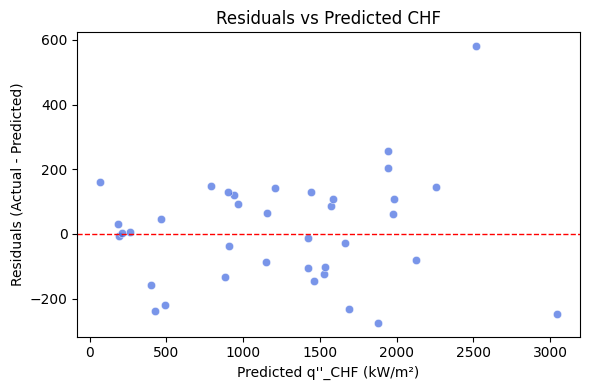

Residuals_vs_Predicted_CHF.jpg saved


In [17]:
# ------------------------------------------------------------
# Residual analysis — Export as 300 DPI JPEG
# ------------------------------------------------------------

residuals = y_test - y_pred      # <-- FIXED

plt.figure(figsize=(6,4))
sns.scatterplot(
    x=y_pred,
    y=residuals,
    color='royalblue',
    alpha=0.7
)

plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs Predicted CHF", fontsize=12)
plt.xlabel("Predicted q''_CHF (kW/m²)")
plt.ylabel("Residuals (Actual - Predicted)")
plt.tight_layout()

# ---- Save as high-quality JPEG ----
plt.savefig(
    "Residuals_vs_Predicted_CHF.jpg",
    format="jpg",
    dpi=300,
    bbox_inches="tight"
)

plt.show()
plt.close()

print("Residuals_vs_Predicted_CHF.jpg saved")


/tmp/ipython-input-4060632798.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


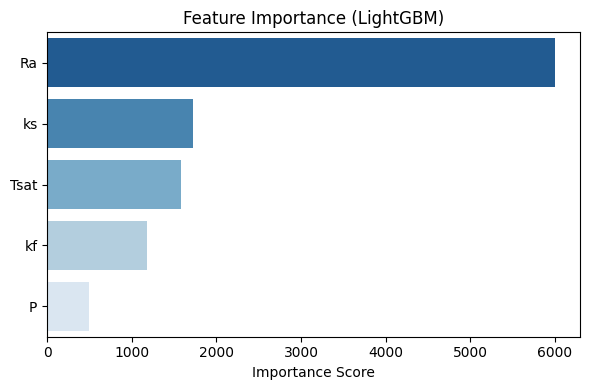

Feature_Importance_LightGBM.jpg saved successfully.


In [18]:
# ------------------------------------------------------------
# Feature Importance (LightGBM) — Export as 300 DPI JPEG
# ------------------------------------------------------------

# Extract the LGBMRegressor from the pipeline
lgbm_model = best_pipe.named_steps['model']

# Build importance dataframe
importance_df = pd.DataFrame({
    "Feature": feature_columns,
    "Importance": lgbm_model.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(
    data=importance_df,
    x="Importance",
    y="Feature",
    palette="Blues_r"
)
plt.title("Feature Importance (LightGBM)", fontsize=12)
plt.xlabel("Importance Score")
plt.ylabel("")
plt.tight_layout()

# ---- Save as JPEG ----
plt.savefig(
    "Feature_Importance_LightGBM.jpg",
    format="jpg",
    dpi=300,
    bbox_inches="tight"
)

# Optional: also save to save_dir
# plt.savefig(
#     f"{save_dir}/Feature_Importance_LightGBM.jpg",
#     format="jpg",
#     dpi=300,
#     bbox_inches="tight"
# )

# Show plot
plt.show()
plt.close()

print("Feature_Importance_LightGBM.jpg saved successfully.")


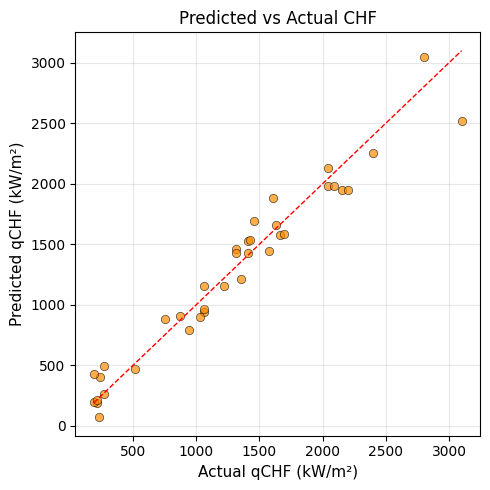

Predicted_vs_Actual_CHF.jpg saved successfully.


In [19]:
# ------------------------------------------------------------
# Predicted vs Actual CHF — Export as 300 DPI JPEG
# ------------------------------------------------------------

plt.figure(figsize=(5,5))
sns.scatterplot(
    x=y_test,       # <-- FIXED
    y=y_pred,       # <-- predicted values
    color='darkorange',
    alpha=0.7,
    edgecolor='k',
    linewidth=0.5
)

# 1:1 reference line
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    'r--', lw=1
)

plt.xlabel("Actual qCHF (kW/m²)", fontsize=11)
plt.ylabel("Predicted qCHF (kW/m²)", fontsize=11)
plt.title("Predicted vs Actual CHF", fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# ---- Save as high-quality JPEG ----
plt.savefig(
    "Predicted_vs_Actual_CHF.jpg",
    format="jpg",
    dpi=300,
    bbox_inches="tight"
)

# Optional: also save to save_dir
# plt.savefig(
#     f"{save_dir}/Predicted_vs_Actual_CHF.jpg",
#     format="jpg",
#     dpi=300,
#     bbox_inches="tight"
# )

plt.show()

print("Predicted_vs_Actual_CHF.jpg saved successfully.")


In [20]:
# Summary Table
summary_table = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R²"],
    "Value": [rmse, mae, r2]
})
print("\nPerformance Summary Table:")
display(summary_table)



Performance Summary Table:


,Metric,Value
0,RMSE,168.171654
1,MAE,131.339942
2,R²,0.950821


In [21]:
#  Ensure SHAP is available
try:
    import shap
except ImportError:
    raise SystemExit("Please install shap first: pip install shap")

# 1) Recompute predictions & metrics (for completeness)
y_pred = best_pipe.predict(pd.DataFrame(X_test, columns=feature_columns))
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
print("MODEL PERFORMANCE SUMMARY (for SHAP report)")
print(f"  RMSE : {rmse:.3f}")
print(f"  MAE  : {mae:.3f}")
print(f"  R²   : {r2:.4f}")
print("-"*60)


MODEL PERFORMANCE SUMMARY (for SHAP report)
  RMSE : 174.929
  MAE  : 131.103
  R²   : 0.9468
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [22]:
# 2) Prepare the imputed test matrix (so SHAP sees what the model saw)
# best_pipe is the LGBMRegressor model directly, not a pipeline with imputer
lgbm = best_pipe

# Manually apply imputation using SimpleImputer fitted on training data
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
imputer.fit(X_train[feature_columns]) # Fit imputer on training data
X_test_imp = pd.DataFrame(imputer.transform(X_test[feature_columns]), columns=feature_columns)


# (Optional) For speed on very large sets, sample the SHAP background:
bg_idx = np.random.RandomState(42).choice(len(X_test_imp),
                                          size=min(200, len(X_test_imp)),
                                          replace=False)
X_bg = X_test_imp.iloc[bg_idx]


In [23]:
# 3) Build a SHAP explainer (TreeExplainer for LightGBM)
#    Handle both plain models and sklearn Pipelines.

# If lgbm is a Pipeline, grab the final LGBMRegressor
if hasattr(lgbm, "named_steps"):
    base_model = lgbm.named_steps.get("model", lgbm)
else:
    base_model = lgbm

try:
    # Preferred: TreeExplainer for tree-based models
    explainer = shap.TreeExplainer(base_model, data=X_bg)
    sv = explainer.shap_values(X_test_imp)
except Exception as e:
    print("TreeExplainer failed, falling back to generic Explainer.")
    print("Reason:", e)
    # Fallback: model-agnostic Explainer
    explainer = shap.Explainer(base_model, X_bg)
    shap_values_obj = explainer(X_test_imp)
    sv = shap_values_obj.values  # (n_samples, n_features)

print("SHAP values shape:", np.array(sv).shape)


SHAP values shape: (37, 5)


In [24]:
# 4) Compute SHAP values
# For newer SHAP, explainer(X) returns a Explanation; older returns array/list
shap_vals = explainer(X_test_imp)

# Normalize to array + ensure 2D for plotting
if hasattr(shap_vals, "values"):
    sv = shap_vals.values
else:
    sv = shap_vals
if isinstance(sv, list):  # older SHAP for multiclass; for regression usually single array
    sv = sv[0]
# sv shape: (n_samples, n_features)


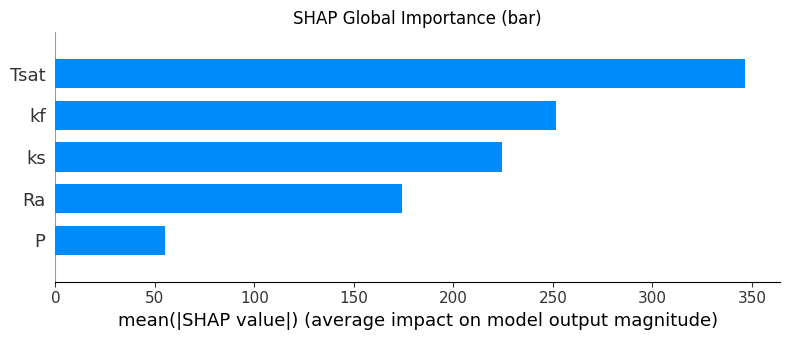

SHAP_Global_Importance_bar.jpg saved successfully.


In [25]:
# ------------------------------------------------------------
# SHAP Global Importance — Bar Chart (300 DPI JPEG)
# ------------------------------------------------------------

plt.figure(figsize=(7, 4))

# SHAP's summary_plot draws directly onto the current figure
shap.summary_plot(sv, X_test_imp, plot_type="bar", show=False)

plt.title("SHAP Global Importance (bar)")
plt.tight_layout()

# ---- Save high-quality JPEG ----
plt.savefig(
    "SHAP_Global_Importance_bar.jpg",
    format="jpg",
    dpi=300,
    bbox_inches="tight"
)

# Optional: also save into save_dir
# plt.savefig(
#     f"{save_dir}/SHAP_Global_Importance_bar.jpg",
#     format="jpg",
#     dpi=300,
#     bbox_inches="tight"
# )

plt.show()
plt.close()

print("SHAP_Global_Importance_bar.jpg saved successfully.")


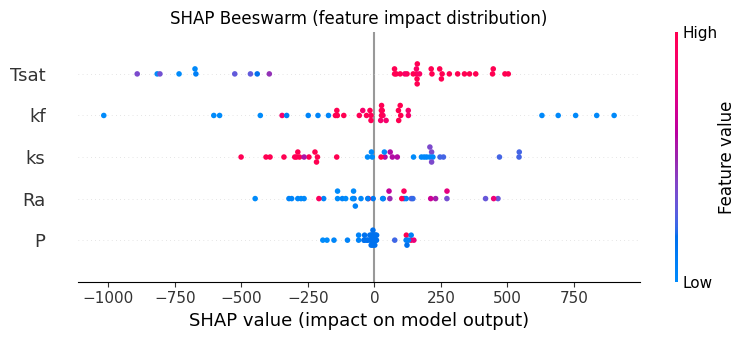

SHAP_Beeswarm_FeatureImpact.jpg saved successfully.


In [26]:
# ------------------------------------------------------------
# SHAP Beeswarm (Feature Impact Distribution) — 300 DPI JPEG
# ------------------------------------------------------------

plt.figure(figsize=(7, 4))

# SHAP's summary_plot draws directly onto the current figure
shap.summary_plot(sv, X_test_imp, show=False)

plt.title("SHAP Beeswarm (feature impact distribution)")
plt.tight_layout()

# ---- Save as high-quality JPEG ----
plt.savefig(
    "SHAP_Beeswarm_FeatureImpact.jpg",
    format="jpg",
    dpi=300,
    bbox_inches="tight"
)

# Optional: also save to save_dir
# plt.savefig(
#     f"{save_dir}/SHAP_Beeswarm_FeatureImpact.jpg",
#     format="jpg",
#     dpi=300,
#     bbox_inches="tight"
# )

plt.show()
plt.close()

print("SHAP_Beeswarm_FeatureImpact.jpg saved successfully.")


Top SHAP features: ['Tsat', 'kf', 'ks']


<Figure size 600x400 with 0 Axes>

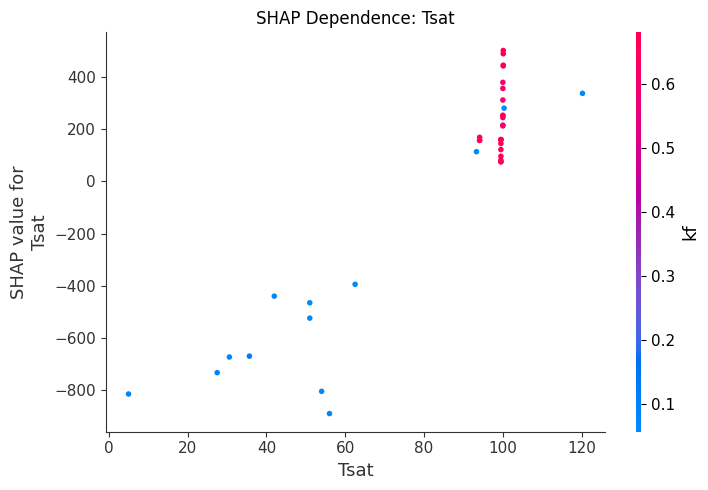

Saved: SHAP_Dependence_Tsat.jpg


<Figure size 600x400 with 0 Axes>

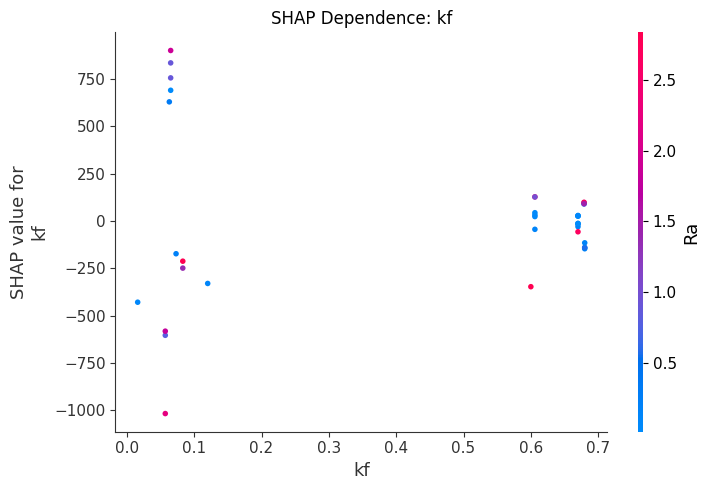

Saved: SHAP_Dependence_kf.jpg


<Figure size 600x400 with 0 Axes>

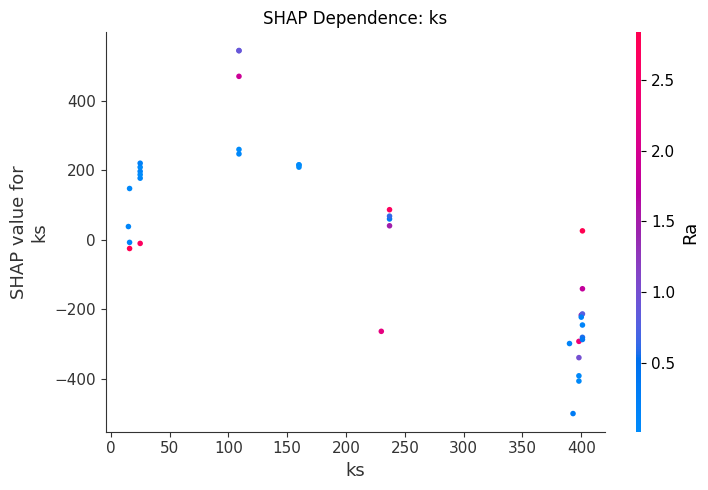

Saved: SHAP_Dependence_ks.jpg


In [27]:
# ------------------------------------------------------------
# 7) SHAP Dependence Plots for Top 3 Features — 300 DPI JPEG
# ------------------------------------------------------------

mean_abs = np.abs(sv).mean(axis=0)
top_idx = np.argsort(-mean_abs)[:3]
top_feats = [feature_columns[i] for i in top_idx]

print("Top SHAP features:", top_feats)

for f in top_feats:
    plt.figure(figsize=(6, 4))

    # SHAP dependence plot (auto-selects interaction feature)
    shap.dependence_plot(f, sv, X_test_imp, show=False)

    plt.title(f"SHAP Dependence: {f}")
    plt.tight_layout()

    # ---- Safe filename ----
    fname = f"SHAP_Dependence_{f}.jpg"
    fname_path = fname.replace("/", "_")   # avoid path conflicts

    # ---- Save JPEG ----
    plt.savefig(
        fname_path,
        format="jpg",
        dpi=300,
        bbox_inches="tight"
    )

    # Optional saving to trained-model directory
    # plt.savefig(f"{save_dir}/{fname_path}", format="jpg", dpi=300, bbox_inches="tight")

    plt.show()

    print(f"Saved: {fname_path}")


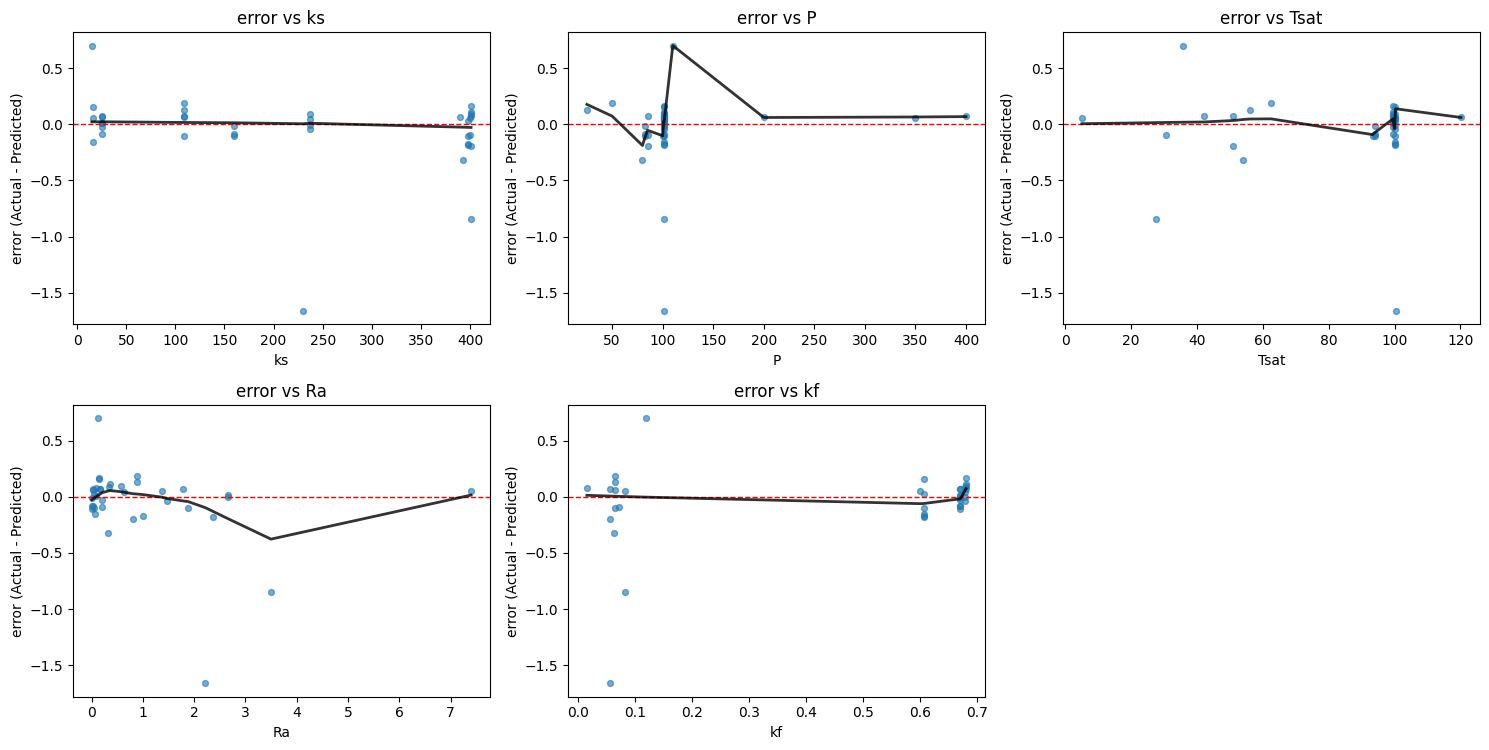

In [28]:
# =========================================
# RESIDUALS-BY-FEATURE GRID
# =========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assumes: best_pipe, X_test, y_test, feature_columns exist
# if y_pred isn't computed yet, do it now:
try:
    y_pred
except NameError:
    y_pred = best_pipe.predict(pd.DataFrame(X_test, columns=feature_columns))

# Define residual/error consistently with label: (Actual - Predicted)/Actual
error = (y_test - y_pred) / y_test

# build plotting DataFrame
plot_df = pd.DataFrame(X_test, columns=feature_columns).copy()
plot_df["error"] = error.values
plot_df["Predicted"] = y_pred
plot_df["Actual"] = y_test.values

# try to import LOWESS for a smooth trend line
try:
    from statsmodels.nonparametric.smoothers_lowess import lowess
    have_lowess = True
except Exception:
    have_lowess = False

# layout
feats = feature_columns
n = len(feats)
cols = 3
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3.8*rows), squeeze=False)
axes = axes.ravel()

for i, f in enumerate(feats):
    ax = axes[i]
    x = plot_df[f].values
    y = plot_df["error"].values

    ax.scatter(x, y, alpha=0.6, s=18)
    ax.axhline(0.0, color="red", linestyle="--", linewidth=1)

    ax.set_title(f"error vs {f}")
    ax.set_xlabel(f)
    ax.set_ylabel("error (Actual - Predicted)")

    # overlay LOWESS if available and enough unique x
    if have_lowess and np.unique(x).size > 10:
        lo = lowess(y, x, frac=0.6, return_sorted=True)
        ax.plot(lo[:, 0], lo[:, 1], color="black", linewidth=2, alpha=0.8)

# turn off any empty subplots
for j in range(i + 1, rows*cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


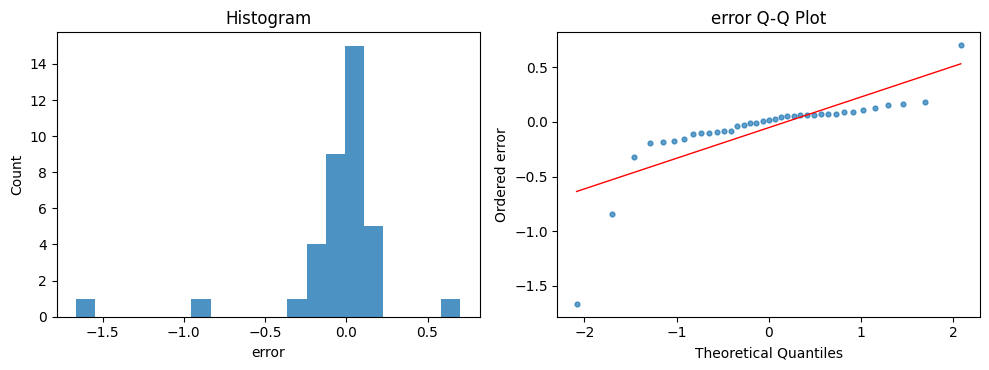

In [29]:
# =========================================
# RESIDUAL HISTOGRAM & Q-Q PLOT
# =========================================
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(10, 3.8))

# Histogram of error
ax[0].hist(error, bins=20, alpha=0.8)
ax[0].set_title("Histogram")
ax[0].set_xlabel("error")
ax[0].set_ylabel("Count")

# Q-Q plot of error
try:
    import scipy.stats as st
    (osm, osr), (slope, intercept, r) = st.probplot(error, dist="norm", plot=None)
    ax[1].scatter(osm, osr, s=12, alpha=0.7)
    line = slope * osm + intercept
    ax[1].plot(osm, line, color="red", linewidth=1)
    ax[1].set_title("error Q-Q Plot")
    ax[1].set_xlabel("Theoretical Quantiles")
    ax[1].set_ylabel("Ordered error")
except Exception:
    ax[1].text(0.5, 0.5, "scipy not available for Q-Q plot",
               ha="center", va="center")
    ax[1].set_axis_off()

plt.tight_layout()
plt.show()
